## Rafael Espinosa Mena
USC ID: 3587389751 <br>
GitHub Username: rafael6423 <br>
DSCI 552 HW6 <br>
Jul 1, 2022

Note: This file contains all the questions from part one (ISLR questions are in another file named EspinosaMena_Rafael_ISLR_HW6.pdf in the notebook folder) except for the LOOCV questions because those were crashing google collab's ram, kaggle's ram and even my computer's ram, so I had to run those separately and put them in another file named EspinosaMena_Rafael_LOOCV_HW6.ipynb in the notebook folder. I am sorry for this, but I hope you understand that this hw was extremely difficult from a computational point of view so this is the only way I could run all the code. I tried to buy collab pro but it is not available in my country, and I was not able to find a computer good enough to run the whole program at once. I sincerely hope I do not get penalized for breaking up the ipynb file up like this.

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from math import floor, sqrt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.model_selection import LeaveOneOut
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import warnings

In [2]:
df_train = pd.read_csv('aps_failure_training_set.csv')
df_test = pd.read_csv('aps_failure_test_set.csv')

### 1.b.i) Commonly Used Methods for Imputation of Missing Values
Using the Mean/Median of the existing values in the column to replace all the missing values in the column, using the most common value in the column to replace all the missing values, using zero or a constant value to replace all the missing values, imputing by using knn to find the average value for that feature from the k-nearest observations that do have values for that feature, Multiple Imputation by Chained Equation (MICE) which imputs data with various different values to measures the uncertainty of the imputted value, using Deep Learning to impute values by using a NN to come up with a good estimate of what that value should be for that observation based on the others, other ML methods such as building a regression model on observations that do have values to "predict" what that value should be.

In [3]:
# impute function
def impute(df, method):
    class_col = pd.DataFrame(df['class'])
    df = df.drop(['class'], axis=1)
    df.replace(('na'), (np.nan), inplace=True)
    imp_mean = SimpleImputer(missing_values = np.nan, strategy = method)
    df_imp = pd.DataFrame(imp_mean.fit_transform(df))
    df_imp.columns = df.columns
    df_1 = pd.concat([class_col, df_imp], axis=1)
    return df_1 

# impute train and test sets separately
train_imp = impute(df_train, 'mean')
test_imp = impute(df_test, 'mean')
# join imputed sets to have data for part b
data_imp = pd.concat([train_imp, test_imp], axis=0, ignore_index=True)

### 1.b.ii) Calculate CV for 170 Features

In [4]:
# create a dataframe to store cv values
cvs_df = pd.DataFrame(columns = ['Feature', 'CV'])

# calculate cv values
for column in data_imp.columns:
    if column != 'class':
        cv = data_imp[column].std()/data_imp[column].mean()
        cvs_df.loc[len(cvs_df),'Feature'] = column
        cvs_df.loc[len(cvs_df)-1,'CV'] = cv
    
# display cv values dataframe
cvs_df

,Feature,CV
0,aa_000,4.328608
1,ab_000,2.178397
2,ac_000,2.167648
3,ad_000,206.786809
4,ae_000,22.293998
...,...,...
165,ee_007,4.885086
166,ee_008,3.335019
167,ee_009,5.753917
168,ef_000,47.925135


### 1.b.iii) Correlation Matrix

Numerical Values of Matrix:


,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
aa_000,1.000000,0.019908,-0.011646,-0.000574,0.025784,0.035977,0.011681,0.076379,0.195163,0.307445,...,0.414127,0.419914,0.409662,0.419784,0.425682,0.356969,0.259670,0.133764,0.006660,0.010344
ab_000,0.019908,1.000000,-0.010893,0.000026,0.024889,0.043279,0.000557,0.006667,0.023633,0.035837,...,0.025249,0.037150,0.028872,0.034329,0.024029,0.013594,0.002437,0.000527,0.046882,0.075719
ac_000,-0.011646,-0.010893,1.000000,-0.002032,-0.004769,-0.010612,0.015535,-0.002333,-0.009436,-0.022885,...,-0.009806,-0.006434,-0.007958,-0.008110,-0.014677,-0.018630,0.010436,0.017292,-0.006192,0.015826
ad_000,-0.000574,0.000026,-0.002032,1.000000,-0.000193,-0.000234,-0.000041,-0.000054,-0.000123,-0.000256,...,-0.000901,-0.000942,-0.000932,-0.000761,-0.000767,-0.000469,-0.000805,-0.000503,-0.000082,-0.000091
ae_000,0.025784,0.024889,-0.004769,-0.000193,1.000000,0.829986,-0.000441,-0.000609,0.001946,0.020674,...,0.012750,0.019440,0.012845,0.026435,0.066532,0.036618,-0.008391,-0.006949,0.063587,0.030854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ee_007,0.356969,0.013594,-0.018630,-0.000469,0.036618,0.046481,0.007631,0.068003,0.181968,0.475571,...,0.442199,0.432911,0.419633,0.380132,0.543449,1.000000,0.227099,0.063065,-0.000312,0.000948
ee_008,0.259670,0.002437,0.010436,-0.000805,-0.008391,-0.010839,0.000067,0.005354,0.009112,0.020687,...,0.442533,0.470574,0.448390,0.394021,0.365686,0.227099,1.000000,0.690147,-0.005169,-0.001952
ee_009,0.133764,0.000527,0.017292,-0.000503,-0.006949,-0.008533,-0.001103,-0.003539,-0.009088,-0.018163,...,0.224587,0.235844,0.220785,0.183844,0.158590,0.063065,0.690147,1.000000,-0.003161,-0.001063
ef_000,0.006660,0.046882,-0.006192,-0.000082,0.063587,0.093474,-0.000076,0.001133,0.005610,0.011018,...,0.003711,0.010169,0.002979,0.026910,0.005291,-0.000312,-0.005169,-0.003161,1.000000,0.222579


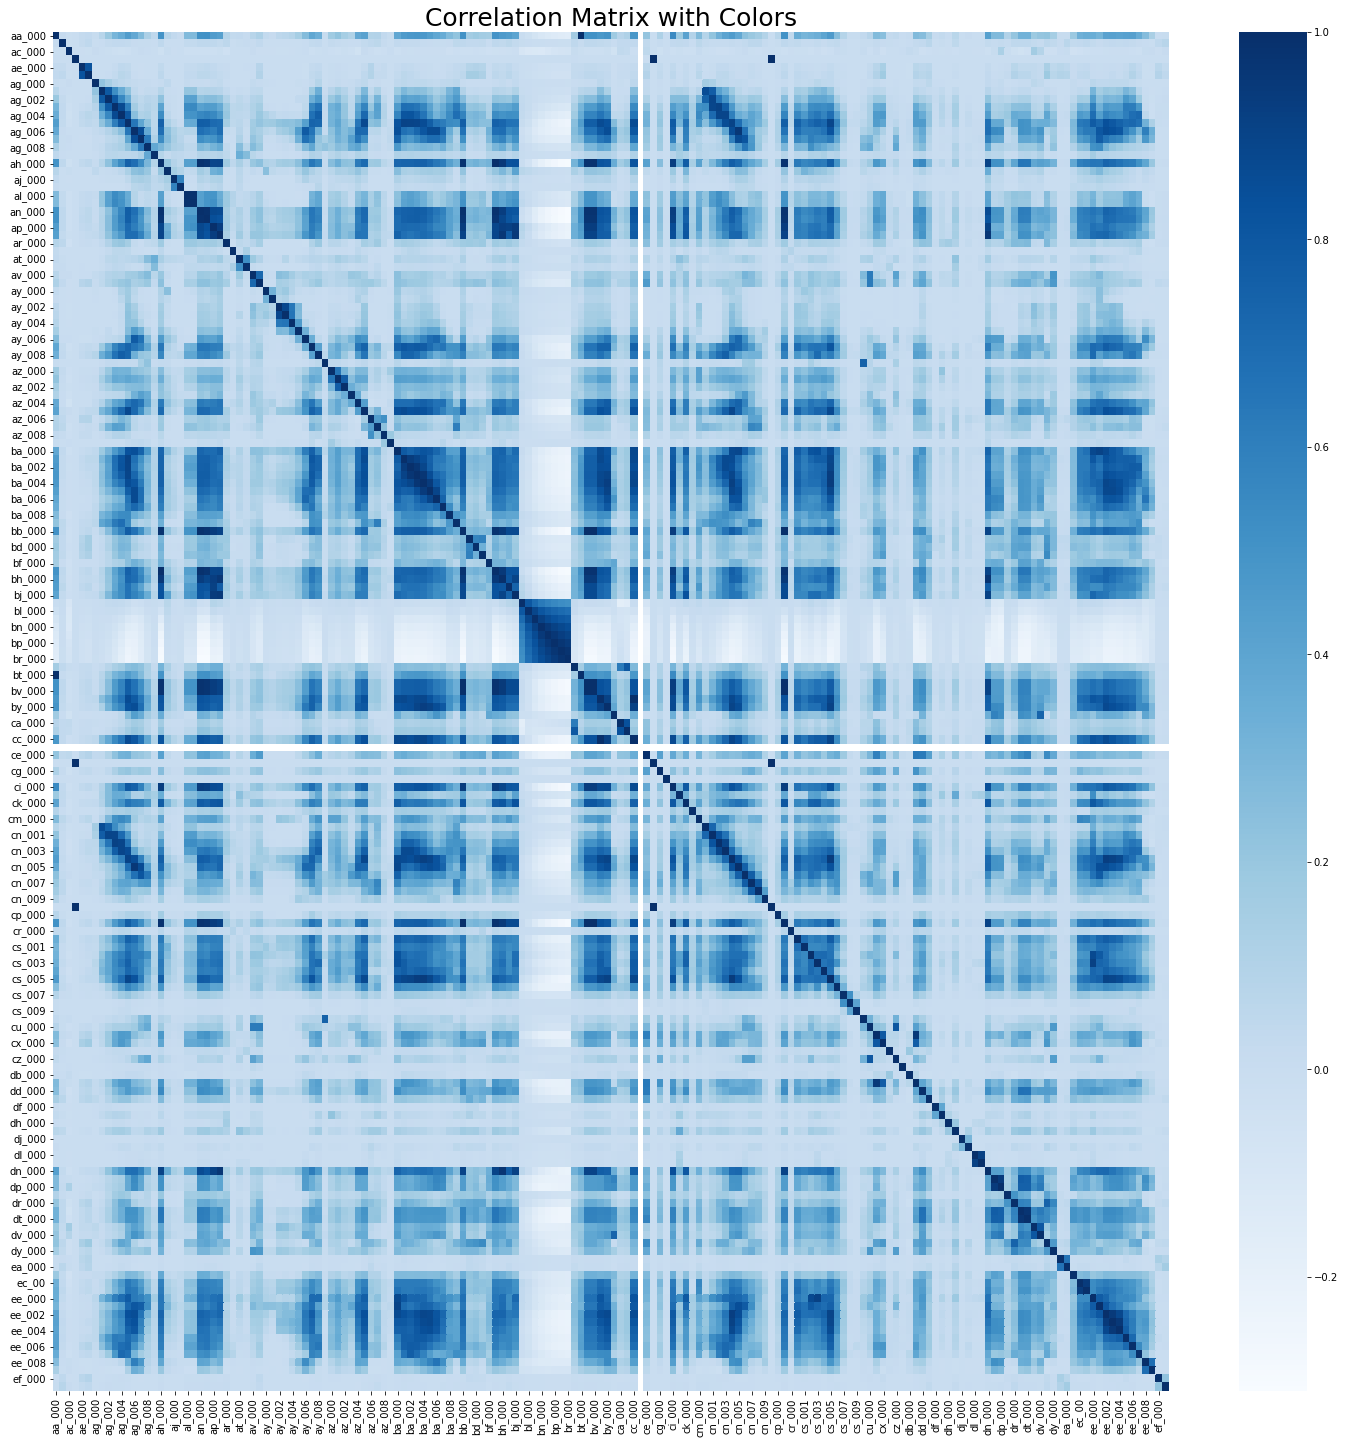

In [5]:
corr_mat = data_imp.drop(['class'], axis=1).corr()
# Plot it numerically
print('Numerical Values of Matrix:')
display(corr_mat)
# Plot it with colors
plt.figure(figsize=(25,25))
sns.heatmap(corr_mat, cmap="Blues")
plt.title('Correlation Matrix with Colors', fontsize = 25)
plt.show()

### 1.b.iv) Scatter/Boxplots of floor(sqrt(170)) Values With Highest CV

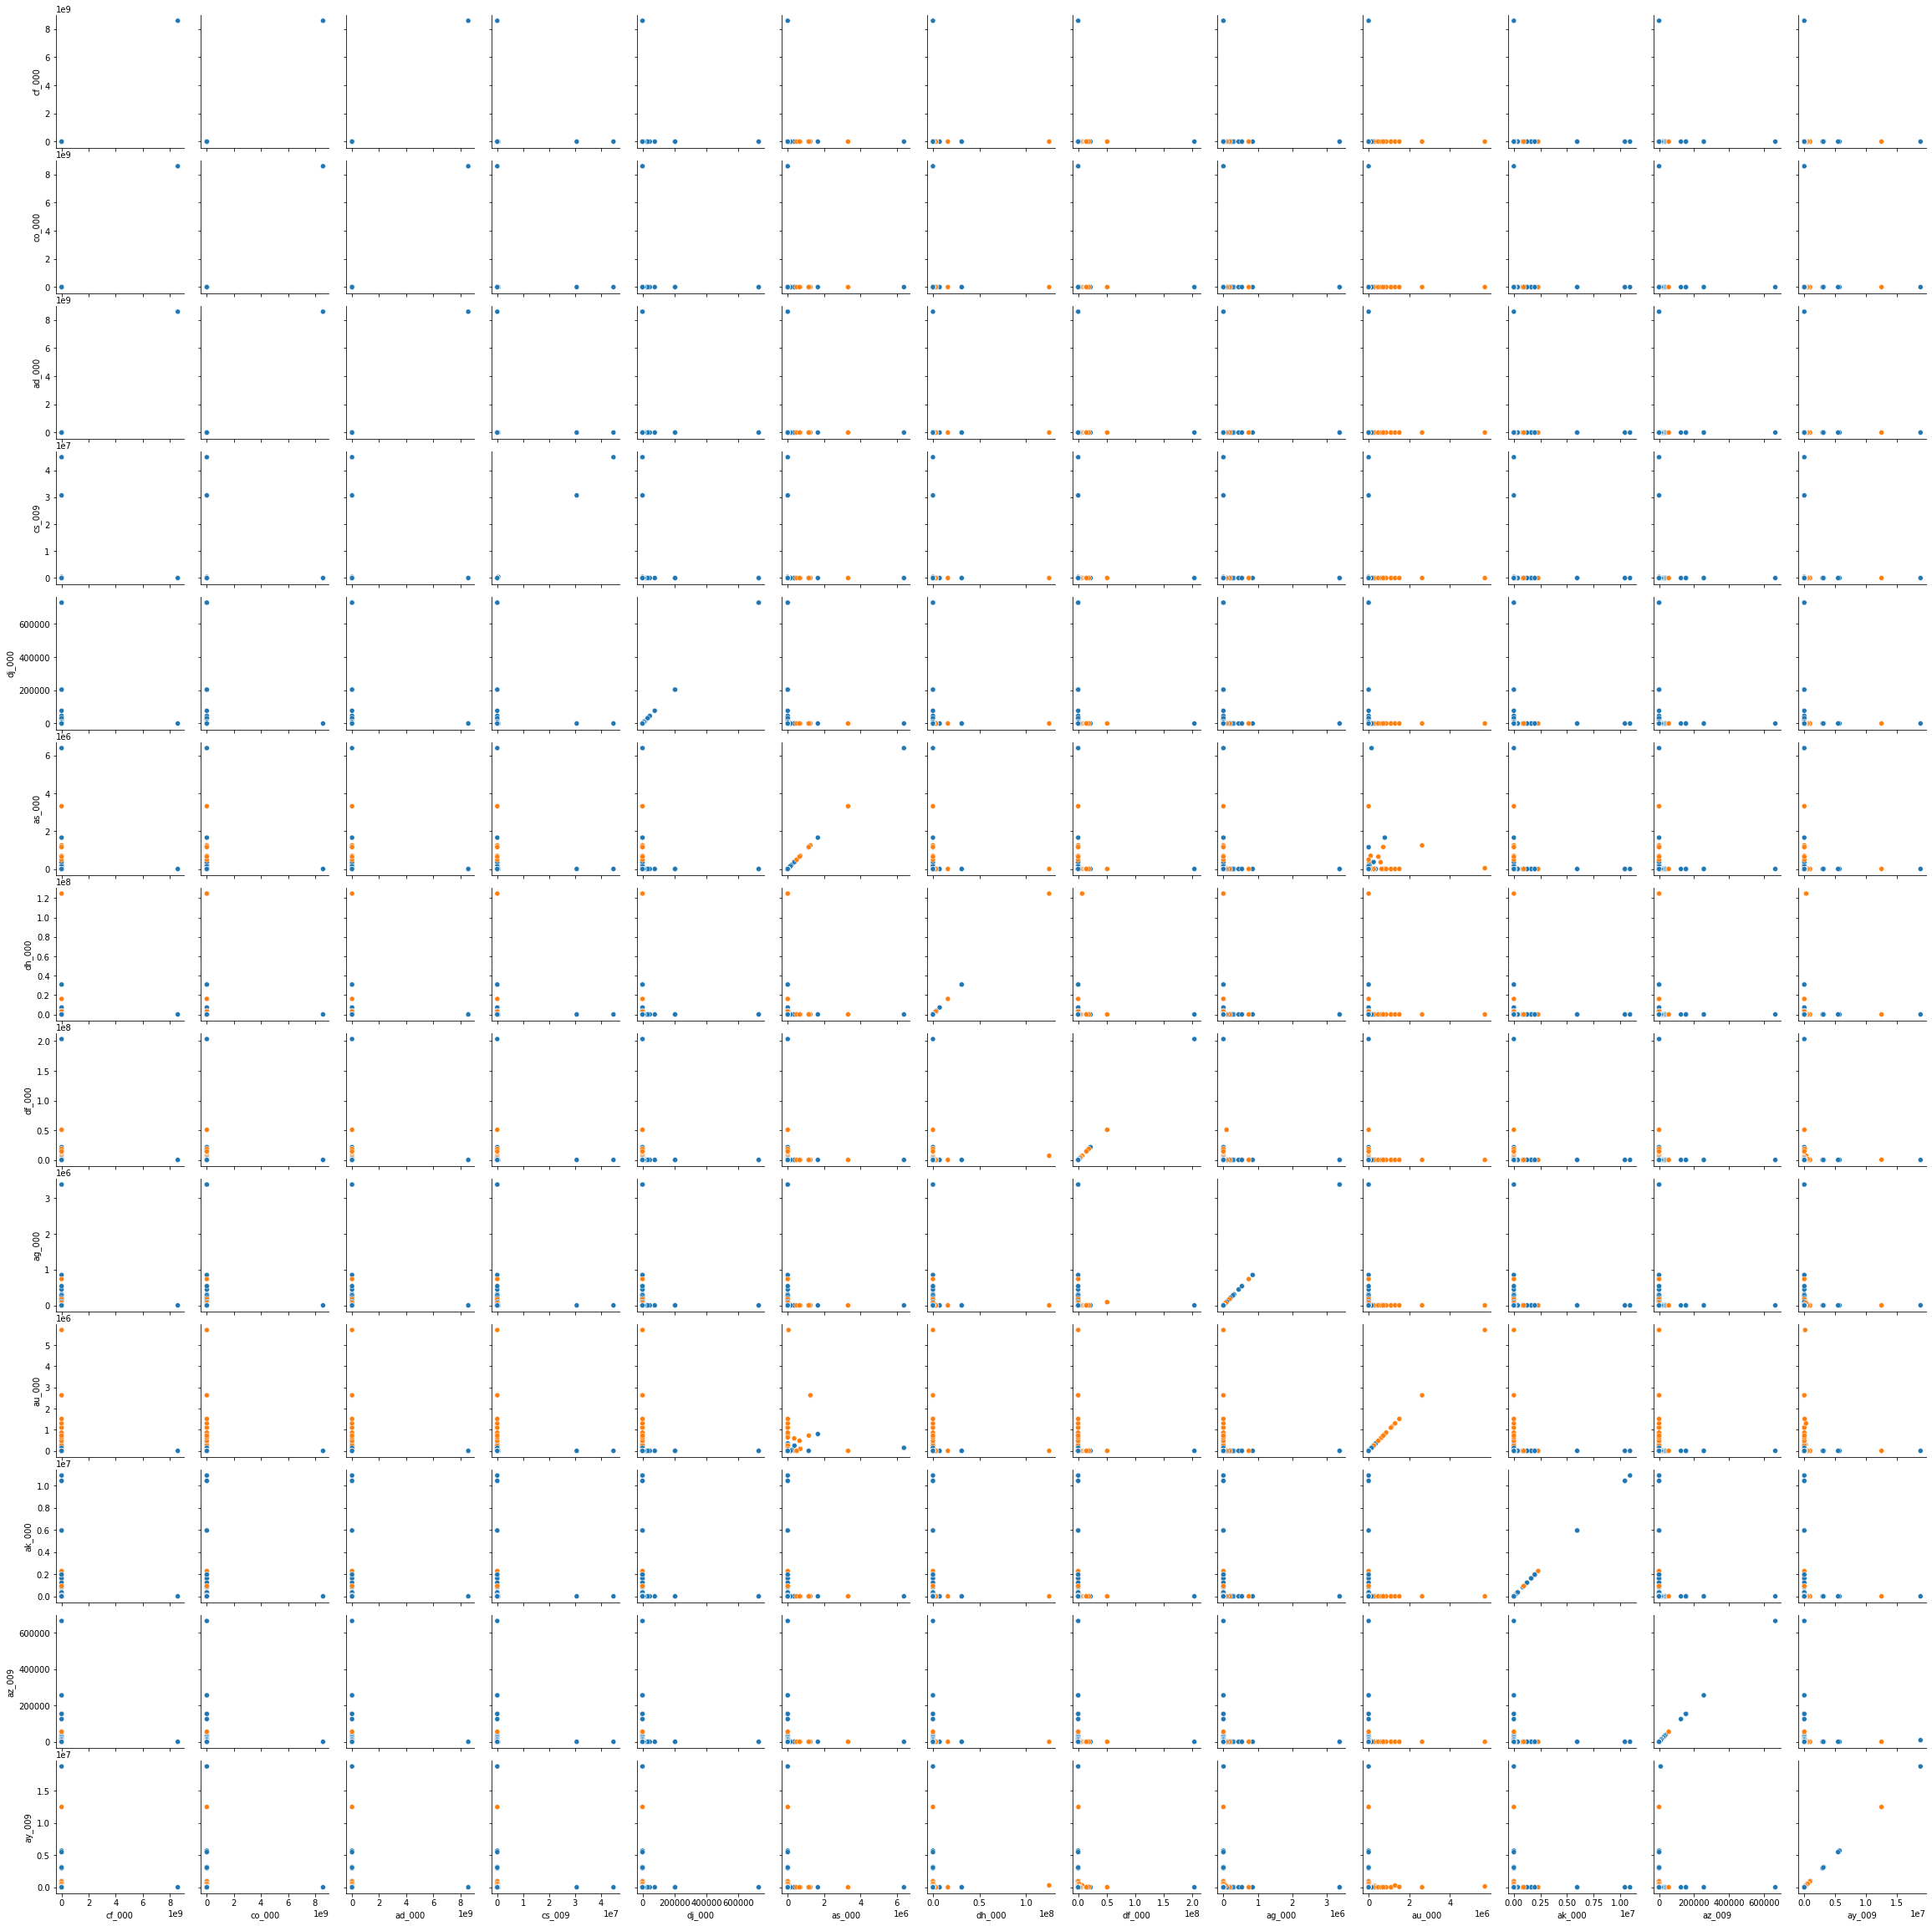

In [6]:
# select the 13 highest CV's
num = floor(sqrt(170))
cvs_df = cvs_df.sort_values('CV', ascending=False, ignore_index = True).iloc[:num,:]

# ScatterPlots
plot_data = data_imp[pd.concat([pd.Series(['class']),cvs_df.Feature], ignore_index=True)]
g = sns.PairGrid(plot_data, hue='class')
g.map(sns.scatterplot)

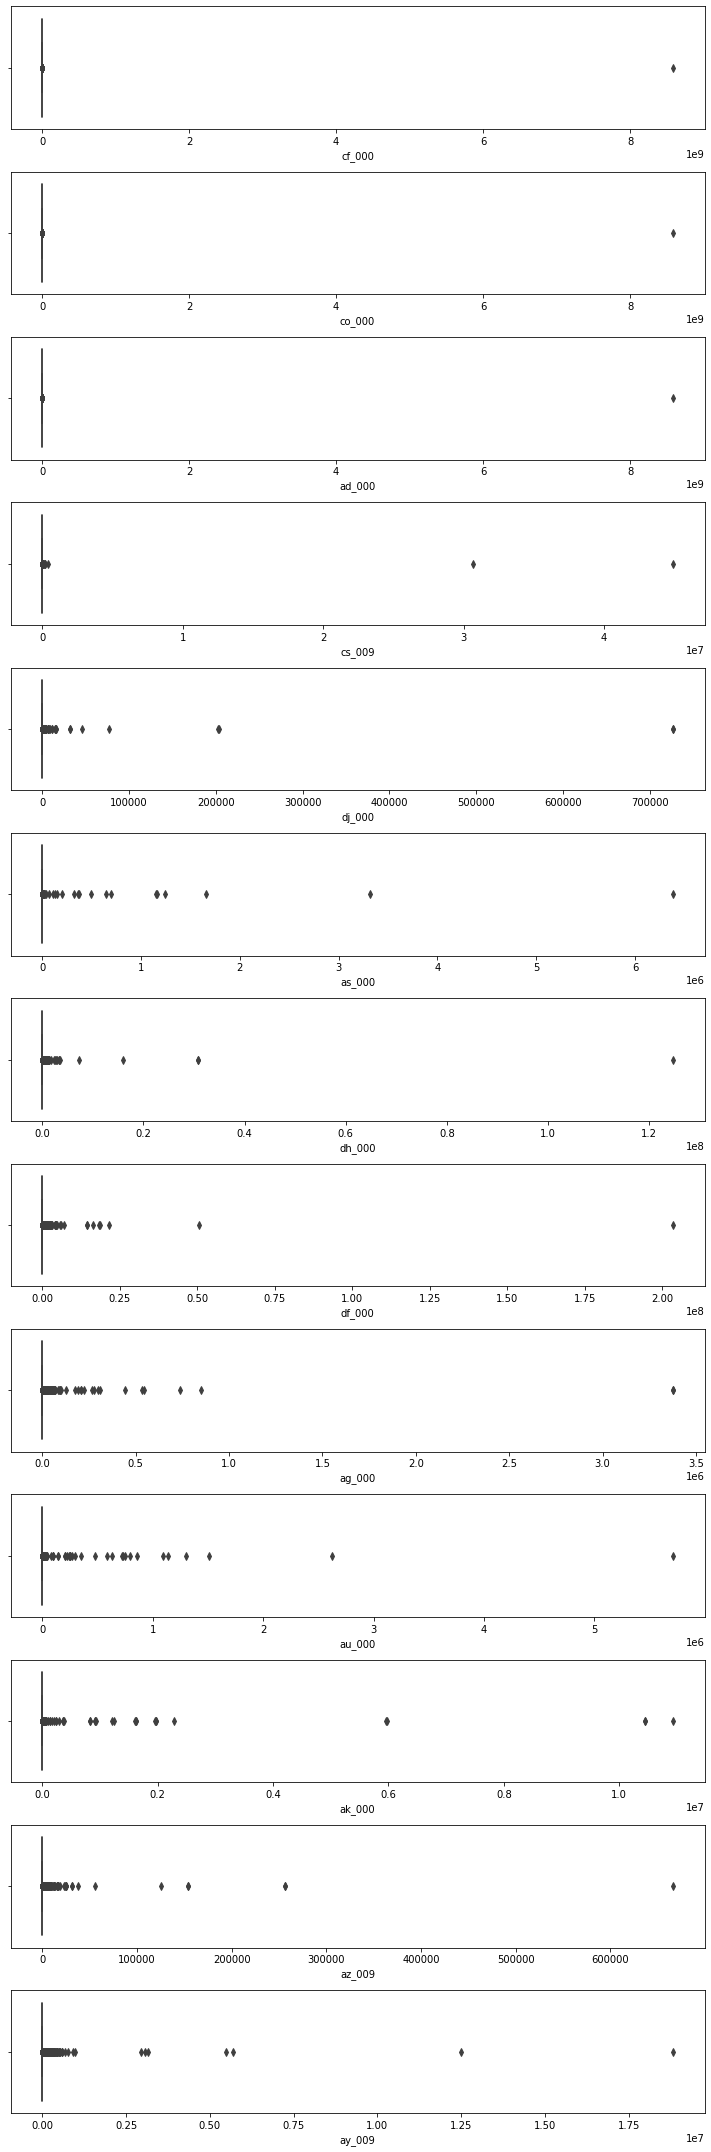

In [7]:
# BoxPlots
fig, axes = plt.subplots(13, 1, figsize=(10,30))
box_data = plot_data.drop(['class'], axis=1)
for i in range(0,13):
    ax = sns.boxplot(x=box_data.columns[i], data=box_data, ax=axes[i])
fig.tight_layout()
plt.show()

### 1.b.v) Determine Number of Positive/Negative Data

In [8]:
print("Train Set Distribution:")
display(df_train['class'].value_counts())
print("Test Set Distribution:")
display(df_test['class'].value_counts())
print("Whole Set Distribution:")
display(data_imp['class'].value_counts())

Train Set Distribution:


neg    59000
pos     1000
Name: class, dtype: int64

Test Set Distribution:


neg    15625
pos      375
Name: class, dtype: int64

Whole Set Distribution:


neg    74625
pos     1375
Name: class, dtype: int64

As we can see, in all of the data there are 74625 negatives and only 1375 positives, meaning that the positives are only 1.8% of the data. Within the training set, this is even more drastic because the positives are only 1.67% of the data points, so this dataset is definetly imbalanced.

### 1.c) Random Forest Classifier Without Class Imbalance Compensation


In [9]:
# create data
y_train = train_imp['class'].map({"neg":0, "pos":1})
x_train = train_imp.drop(['class'], axis=1)
y_test = test_imp['class'].map({"neg":0, "pos":1})
x_test = test_imp.drop(['class'], axis=1)

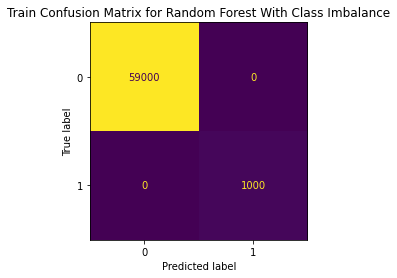

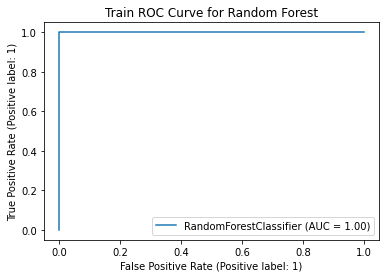

Train AUC Score for Random Forest is 1.0
Train OOB Error for Random Forest is 0
Train Misclassification Rate for Random Forest is 0.0


In [10]:
# create and fit RFC model
clf = RandomForestClassifier(random_state=0, oob_score=True)
clf.fit(x_train, y_train)

# create predictions
train_pred = clf.predict(x_train)
test_pred = clf.predict(x_test)

# Calculations for Training Set
# Confusion Matrix
ax = plt.subplot(1, 1, 1)
ax.grid(False)
conf_matrix = confusion_matrix(y_train, train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(ax=ax, colorbar=False)
plt.title('Train Confusion Matrix for Random Forest With Class Imbalance')
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(clf, x_train, y_train)
plt.title('Train ROC Curve for Random Forest')
plt.show()

# Scores 
print("Train AUC Score for Random Forest is", roc_auc_score(y_train, train_pred))
print("Train OOB Error for Random Forest is", 1-clf.oob_score)
print("Train Misclassification Rate for Random Forest is", 1-accuracy_score(y_train, train_pred))

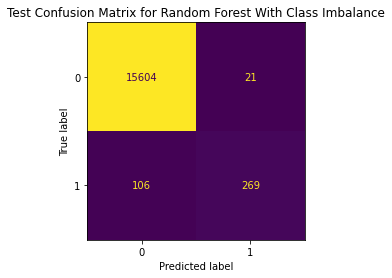

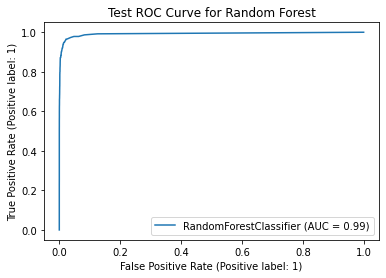

Test AUC Score for Random Forest is 0.8579946666666667
Test OOB Error for Random Forest is 0
Test Misclassification Rate for Random Forest is 0.007937500000000042


In [11]:

# Calculations for Test Set
# Confusion Matrix
ax = plt.subplot(1, 1, 1)
ax.grid(False)
conf_matrix = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(ax=ax, colorbar=False)
plt.title('Test Confusion Matrix for Random Forest With Class Imbalance')
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(clf, x_test, y_test)
plt.title('Test ROC Curve for Random Forest')
plt.show()

# Scores 
print("Test AUC Score for Random Forest is", roc_auc_score(y_test, test_pred))
print("Test OOB Error for Random Forest is", 1-clf.oob_score)
print("Test Misclassification Rate for Random Forest is", 1-accuracy_score(y_test, test_pred))

### 1.d)  Random Forest with Class Imbalance Compensation
From my research, I can see tthat one common method to deal with class imbalances in Random Forest Classfiers is to make class priors equal by downsampling or upsampling by drawing bootstrap samples of equal proportions from the both the minority and majority class. In practice, we can directly use a balanced RFC from imblearn or use the typical sklearn RFC but setting the class_weight attribute to 'balanced', and that way it will select points at a rate inversely proportional to how frequent they appear in data.

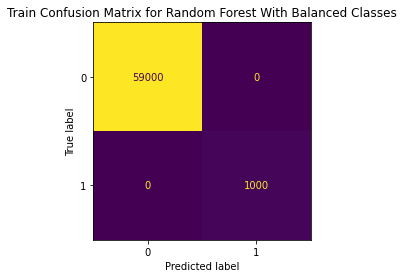

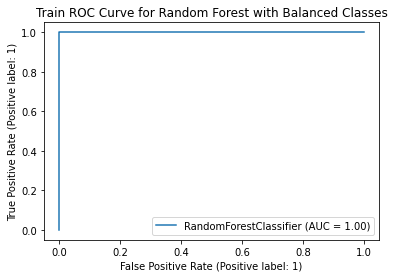

Balanced Train AUC Score for Random Forest is 1.0
Balanced Train OOB Error for Random Forest is 0
Balanced Train Misclassification Rate for Random Forest is 0.0


In [12]:
# create and fit model
clf_balanced = RandomForestClassifier(random_state=0, oob_score=True, class_weight="balanced")
clf_balanced.fit(x_train, y_train)

# create predictions
train_pred = clf_balanced.predict(x_train)
test_pred = clf_balanced.predict(x_test)

# Calculations for Training Set (Class Balanced)
# Confusion Matrix
ax = plt.subplot(1, 1, 1)
ax.grid(False)
conf_matrix = confusion_matrix(y_train, train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(ax=ax, colorbar=False)
plt.title('Train Confusion Matrix for Random Forest With Balanced Classes')
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(clf_balanced, x_train, y_train)
plt.title('Train ROC Curve for Random Forest with Balanced Classes')
plt.show()

# Scores 
print("Balanced Train AUC Score for Random Forest is", roc_auc_score(y_train, train_pred))
print("Balanced Train OOB Error for Random Forest is", 1-clf.oob_score)
print("Balanced Train Misclassification Rate for Random Forest is", 1-accuracy_score(y_train, train_pred))

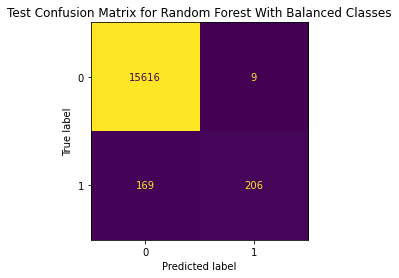

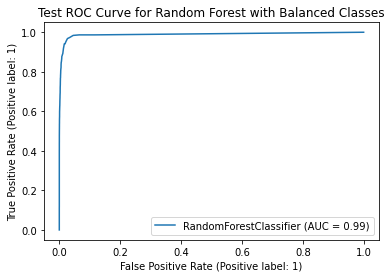

Balanced Test AUC Score for Random Forest is 0.7743786666666665
Balanced Test OOB Error for Random Forest is 0
Balanced Test Misclassification Rate for Random Forest is 0.011125000000000052


In [13]:
# Calculations for Test Set
# Confusion Matrix
ax = plt.subplot(1, 1, 1)
ax.grid(False)
conf_matrix = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(ax=ax, colorbar=False)
plt.title('Test Confusion Matrix for Random Forest With Balanced Classes')
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(clf_balanced, x_test, y_test)
plt.title('Test ROC Curve for Random Forest with Balanced Classes')
plt.show()

# Scores 
print("Balanced Test AUC Score for Random Forest is", roc_auc_score(y_test, test_pred))
print("Balanced Test OOB Error for Random Forest is", 1-clf.oob_score)
print("Balanced Test Misclassification Rate for Random Forest is", 1-accuracy_score(y_test, test_pred))

#### Comparison with results of 1c
For the imbalanced algorithm in 1c, we got perfect training scores and a test AUC of 0.857 and test error of 0.0079. For the balanced algorithm in 1d, we also got perfect training scores but a test AUC score of 0.774 and test error of 0.0111, both of which are substantially worse than for the imbalanced one. This maybe has to do with the fact that once we "balance" the classes, it is not representative of the true proportion of cases in the test set and for the data in general, so it won't be able to perform well on the test data.

### 1.e.i) XGBoost and Model Trees: 5 Fold CV

Best Alpha found is 2


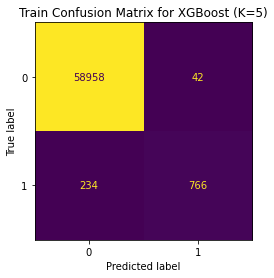

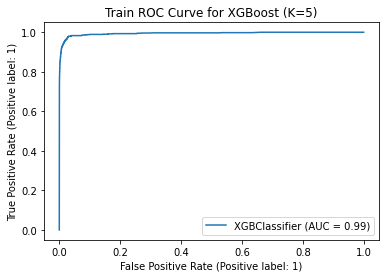

Train AUC Score for XGBoost (K=5) is 0.8826440677966102
Train Misclassification Rate for XGBoost (K=5) is 0.0046000000000000485


In [15]:
# 5 fold CV
warnings.filterwarnings('ignore')
alpha_params = [{'reg_alpha': [0.1, 1, 2]}]
k_5 = model_selection.KFold(n_splits=5, shuffle=True, random_state=0)
xgb_cl = xgb.XGBClassifier(random_state=0, verbosity=0, reg_lambda=0, silent=True)
xgb_cv = GridSearchCV(xgb_cl, alpha_params, cv=k_5.split(x_train, y_train.values.ravel()))
xgb_cv.fit(x_train, y_train.values.ravel())

# create model using best alpha found through CV (K=5)
xgb_model = xgb.XGBClassifier(random_state=0, verbosity=0, reg_lambda=0,
                             reg_alpha=xgb_cv.best_params_['reg_alpha'])
xgb_model.fit(x_train, y_train.values.ravel())
train_pred = xgb_model.predict(x_train)

print("Best Alpha found is", xgb_cv.best_params_['reg_alpha'])

# Training Set
# Confusion Matrix
ax = plt.subplot(1, 1, 1)
ax.grid(False)
conf_matrix = confusion_matrix(y_train, train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(ax=ax, colorbar=False)
plt.title('Train Confusion Matrix for XGBoost (K=5)')
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(xgb_model, x_train, y_train)
plt.title('Train ROC Curve for XGBoost (K=5)')
plt.show()


# Scores 
print("Train AUC Score for XGBoost (K=5) is", roc_auc_score(y_train, train_pred))
print("Train Misclassification Rate for XGBoost (K=5) is", 1-accuracy_score(y_train, train_pred))

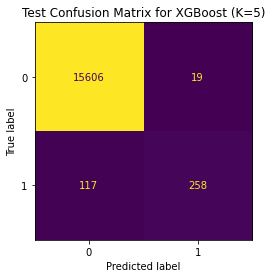

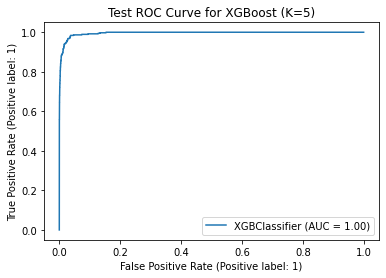

Test AUC Score for XGBoost (K=5) is 0.8433919999999999
Test Misclassification Rate for XGBoost (K=5) is 0.008499999999999952


In [16]:
# Test Set
test_pred = xgb_model.predict(x_test)
# Confusion Matrix
ax = plt.subplot(1, 1, 1)
ax.grid(False)
conf_matrix = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(ax=ax, colorbar=False)
plt.title('Test Confusion Matrix for XGBoost (K=5)')
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(xgb_model, x_test, y_test)
plt.title('Test ROC Curve for XGBoost (K=5)')
plt.show()


# Scores 
print("Test AUC Score for XGBoost (K=5) is", roc_auc_score(y_test, test_pred))
print("Test Misclassification Rate for XGBoost (K=5) is", 1-accuracy_score(y_test, test_pred))

### 1.e.ii) XGBoost and Model Trees: 10 Fold CV

Best Alpha found is 0.1


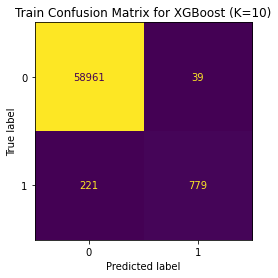

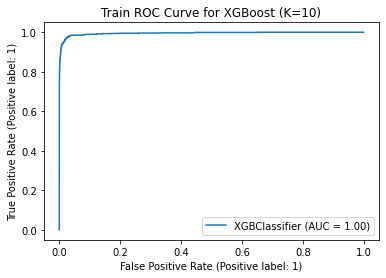

Train AUC Score for XGBoost (K=10) is 0.8891694915254237
Train Misclassification Rate for XGBoost (K=10) is 0.0043333333333333


In [17]:
# 10 fold CV
alpha_params = [{'reg_alpha': [0.1, 1, 2]}]
k_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=0)
xgb_cl = xgb.XGBClassifier(random_state=0, verbosity=0, reg_lambda=0, silent=True)
xgb_cv = GridSearchCV(xgb_cl, alpha_params, cv=k_10.split(x_train, y_train.values.ravel()))
xgb_cv.fit(x_train, y_train.values.ravel())

# create model using best alpha found through CV (K=10)
xgb_model = xgb.XGBClassifier(random_state=0, verbosity=0, reg_lambda=0,
                             reg_alpha=xgb_cv.best_params_['reg_alpha'])
xgb_model.fit(x_train, y_train.values.ravel())
train_pred = xgb_model.predict(x_train)

print("Best Alpha found is", xgb_cv.best_params_['reg_alpha'])

# Training Set
# Confusion Matrix
ax = plt.subplot(1, 1, 1)
ax.grid(False)
conf_matrix = confusion_matrix(y_train, train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(ax=ax, colorbar=False)
plt.title('Train Confusion Matrix for XGBoost (K=10)')
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(xgb_model, x_train, y_train)
plt.title('Train ROC Curve for XGBoost (K=10)')
plt.show()


# Scores 
print("Train AUC Score for XGBoost (K=10) is", roc_auc_score(y_train, train_pred))
print("Train Misclassification Rate for XGBoost (K=10) is", 1-accuracy_score(y_train, train_pred))

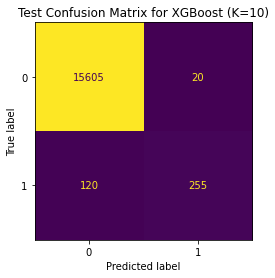

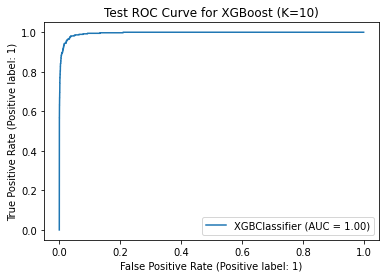

Test AUC Score for XGBoost (K=10) is 0.8393600000000001
Test Misclassification Rate for XGBoost (K=10) is 0.008750000000000036


In [18]:
# Test Set
test_pred = xgb_model.predict(x_test)
# Confusion Matrix
ax = plt.subplot(1, 1, 1)
ax.grid(False)
conf_matrix = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(ax=ax, colorbar=False)
plt.title('Test Confusion Matrix for XGBoost (K=10)')
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(xgb_model, x_test, y_test)
plt.title('Test ROC Curve for XGBoost (K=10)')
plt.show()


# Scores 
print("Test AUC Score for XGBoost (K=10) is", roc_auc_score(y_test, test_pred))
print("Test Misclassification Rate for XGBoost (K=10) is", 1-accuracy_score(y_test, test_pred))

### 1.e.iii) XGBoost and Model Trees: LOOCV
In the EspinosaMena_Rafael_LOOCV_HW6.ipynb file in the notebook folder because it crashed the ram when I ran it all together here.

### 1.f.i) SMOTE XGBoost: 5 Fold

Best Alpha found is 0.1


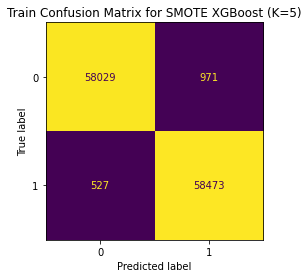

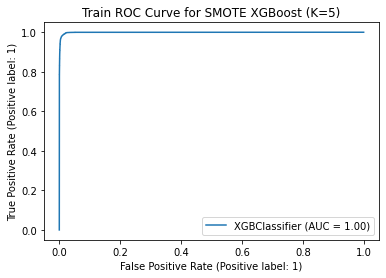

Train AUC Score for SMOTE XGBoost (K=5) is 0.9873050847457627
Train Misclassification Rate for SMOTE XGBoost (K=5) is 0.012694915254237271


In [19]:
# Perform SMOTE
x_train, y_train = SMOTE().fit_resample(x_train, y_train)

# Redo 1.e with SMOTE Train Set
alpha_params = [{'reg_alpha': [0.1, 1, 2]}]

# 5 fold CV
k_5 = model_selection.KFold(n_splits=5, shuffle=True, random_state=0)
xgb_cl = xgb.XGBClassifier(random_state=0, verbosity=0, reg_lambda=0, silent=True)
xgb_cv = GridSearchCV(xgb_cl, alpha_params, cv=k_5.split(x_train, y_train.values.ravel()))
xgb_cv.fit(x_train, y_train.values.ravel())

# create model using best alpha found through CV (K=5)
xgb_model = xgb.XGBClassifier(random_state=0, verbosity=0, reg_lambda=0,
                             reg_alpha=xgb_cv.best_params_['reg_alpha'])
xgb_model.fit(x_train, y_train.values.ravel())
train_pred = xgb_model.predict(x_train)

print("Best Alpha found is", xgb_cv.best_params_['reg_alpha'])

# Training Set
# Confusion Matrix
ax = plt.subplot(1, 1, 1)
ax.grid(False)
conf_matrix = confusion_matrix(y_train, train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(ax=ax, colorbar=False)
plt.title('Train Confusion Matrix for SMOTE XGBoost (K=5)')
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(xgb_model, x_train, y_train)
plt.title('Train ROC Curve for SMOTE XGBoost (K=5)')
plt.show()

# Scores 
print("Train AUC Score for SMOTE XGBoost (K=5) is", roc_auc_score(y_train, train_pred))
print("Train Misclassification Rate for SMOTE XGBoost (K=5) is", 1-accuracy_score(y_train, train_pred))

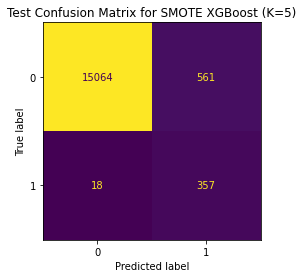

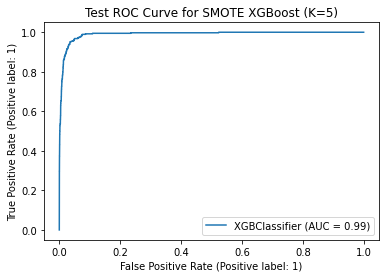

Test AUC Score for SMOTE XGBoost (K=5) is 0.9580479999999999
Test Misclassification Rate for SMOTE XGBoost (K=5) is 0.03618750000000004


In [20]:
# Test Set
test_pred = xgb_model.predict(x_test)
# Confusion Matrix
ax = plt.subplot(1, 1, 1)
ax.grid(False)
conf_matrix = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(ax=ax, colorbar=False)
plt.title('Test Confusion Matrix for SMOTE XGBoost (K=5)')
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(xgb_model, x_test, y_test)
plt.title('Test ROC Curve for SMOTE XGBoost (K=5)')
plt.show()


# Scores 
print("Test AUC Score for SMOTE XGBoost (K=5) is", roc_auc_score(y_test, test_pred))
print("Test Misclassification Rate for SMOTE XGBoost (K=5) is", 1-accuracy_score(y_test, test_pred))

### 1.f.ii) SMOTE XGBoost: 10 Fold

Best Alpha found is 0.1


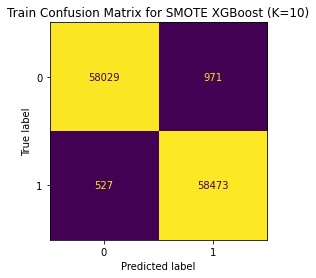

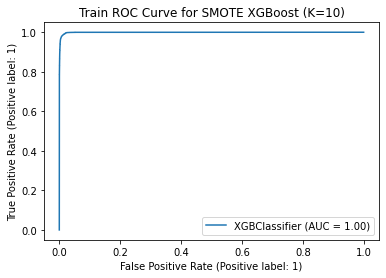

Train AUC Score for SMOTE XGBoost (K=10) is 0.9873050847457627
Train Misclassification Rate for SMOTE XGBoost (K=10) is 0.012694915254237271


In [21]:
# 10 fold CV SMOTE
alpha_params = [{'reg_alpha': [0.1, 1, 2]}]
k_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=0)
xgb_cl = xgb.XGBClassifier(random_state=0, verbosity=0, reg_lambda=0, silent=True)
xgb_cv = GridSearchCV(xgb_cl, alpha_params, cv=k_10.split(x_train, y_train.values.ravel()))
xgb_cv.fit(x_train, y_train.values.ravel())

# create model using best alpha found through CV (K=10)
xgb_model = xgb.XGBClassifier(random_state=0, verbosity=0, reg_lambda=0,
                             reg_alpha=xgb_cv.best_params_['reg_alpha'])
xgb_model.fit(x_train, y_train.values.ravel())
train_pred = xgb_model.predict(x_train)

print("Best Alpha found is", xgb_cv.best_params_['reg_alpha'])

# Training Set
# Confusion Matrix
ax = plt.subplot(1, 1, 1)
ax.grid(False)
conf_matrix = confusion_matrix(y_train, train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(ax=ax, colorbar=False)
plt.title('Train Confusion Matrix for SMOTE XGBoost (K=10)')
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(xgb_model, x_train, y_train)
plt.title('Train ROC Curve for SMOTE XGBoost (K=10)')
plt.show()


# Scores 
print("Train AUC Score for SMOTE XGBoost (K=10) is", roc_auc_score(y_train, train_pred))
print("Train Misclassification Rate for SMOTE XGBoost (K=10) is", 1-accuracy_score(y_train, train_pred))

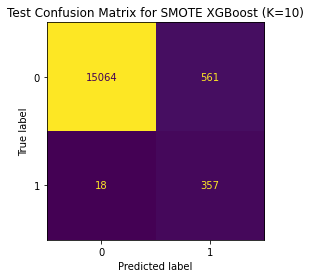

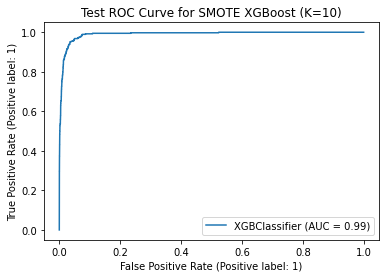

Test AUC Score for SMOTE XGBoost (K=10) is 0.9580479999999999
Test Misclassification Rate for SMOTE XGBoost (K=10) is 0.03618750000000004


In [22]:
# Test Set
test_pred = xgb_model.predict(x_test)
# Confusion Matrix
ax = plt.subplot(1, 1, 1)
ax.grid(False)
conf_matrix = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(ax=ax, colorbar=False)
plt.title('Test Confusion Matrix for SMOTE XGBoost (K=10)')
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(xgb_model, x_test, y_test)
plt.title('Test ROC Curve for SMOTE XGBoost (K=10)')
plt.show()


# Scores 
print("Test AUC Score for SMOTE XGBoost (K=10) is", roc_auc_score(y_test, test_pred))
print("Test Misclassification Rate for SMOTE XGBoost (K=10) is", 1-accuracy_score(y_test, test_pred))

### 1.f.iii) SMOTE XGBoost: LOOCV
In the EspinosaMena_Rafael_LOOCV_HW6.ipynb file in the notebook folder because it crashed the ram when I ran it all together here.

#### Comparison of Uncompensated vs SMOTE case
Without smote, we got a train AUC Score for K=5 of 0.882 and train Misclassification Rate for K=5 of 0.0046, test AUC Score for K=5 of 0.843 and test Misclassification Rate for K=5 of 0.0085. For SMOTE K=5, we got train AUC Score of 0.987 and train Misclassification Rate of 0.01269, with test AUC Score of 0.958 and test Misclassification Rate of 0.0362, so it is hard to say for the k=5 case since the test AUC score is higher for one but the missclassification rate is worse. For the k=10 case, we got a test AUC Score of 0.8393 and test Misclassification Rate of 0.00875 without smote and Test AUC Score of 0.958, test Misclassification Rate of 0.0362 with smote so again a better AUC score but worse classification rate. I think this discrepancy comes from the fact that with smote, we have more data points so there will be a bigger inclination to increase the area under the curve as there are more points to be classified correctly (even if overall a smaller percentage will be classified correctly), which is why the AUC score is higher but again, the new points are artificial so they decrease the accuracy of the model, which is ultimately what we are after.

For the LOOCV case (in the other ipynb file), we see a Test AUC Score of 0.944 aest Misclassification Rate of 0.0208 without smote, and Test AUC Score of 0.9638, test Misclassification Rate of 0.03006 with smote which follows the same pattern as the others: higher AUC score but worse classification rate. Overall, this hints that the smote model should not be used, and the culprit is probably the very high number of artificial points, given that originally the smaller class was less than 2% of the whole data but then after smote it became 50%, meaning a lot of "artificial" points were created. Also, the smote program took longer to run not only because we needed to actually apply the smote procedure to the data, but because we then had to Cross Validate accross many more data points. This was especially difficult with LOOCV.